In [1]:
import sys

sys.path.append("..")
sys.path.append("../../")
sys.path.append("../../src")

import os
import jax
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt
from jax import lax
from matplotlib.patches import Circle
from functional_autoencoders.datasets import get_dataloaders
from functional_autoencoders.datasets.navier_stokes import NavierStokes
from functional_autoencoders.util import pickle_load, get_raw_x

# %load_ext autoreload
# %autoreload 2

key = jax.random.PRNGKey(42)

In [2]:
MODEL_OUT_DIR = "../../tmp/experiments/sparse_training/models"
VISCOSITY = 1e-4

train_dataloader_full, test_dataloader_full = get_dataloaders(
    NavierStokes, data_base="../..", viscosity=VISCOSITY, resolution=64, load_fast=True
)

info = pickle_load(os.path.join(MODEL_OUT_DIR, "model.pkl"))
results = info["results"]
autoencoder = info["autoencoder"]
state = results["state"]

In [3]:
def get_mask(n_base, square_length, top_left_x, top_left_y):
    mask = jnp.zeros((n_base, n_base), dtype=bool)
    rect = jnp.ones((square_length, square_length), dtype=bool)
    mask = lax.dynamic_update_slice(mask, rect, (top_left_y, top_left_x)).flatten()
    return mask


def get_mask_circle(n_base, radius, center_x, center_y):
    radius = int(radius * n_base)
    center_x = int(center_x * n_base)
    center_y = int(center_y * n_base)

    mask = jnp.zeros((n_base, n_base), dtype=bool)
    x = jnp.arange(n_base)
    y = jnp.arange(n_base)
    xx, yy = jnp.meshgrid(x, y, indexing="xy")
    mask = (xx - center_x) ** 2 + (yy - center_y) ** 2 < radius**2

    return mask.flatten()


def plot_circle_patch(
    u_base, mask, n_base, radius, center_x, center_y, vmin=None, vmax=None
):
    radius = int(radius * n_base)
    center_x = int(center_x * n_base)
    center_y = int(center_y * n_base)

    x_min, x_max = center_x - radius, center_x + radius
    y_min, y_max = center_y + radius, center_y - radius

    u_base_masked = np.copy(u_base)
    u_base_masked[~mask] = np.nan  # Set values outside the circle to NaN

    plt.imshow(u_base_masked.reshape(n_base, n_base), cmap="hot", vmin=vmin, vmax=vmax)
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)

    plt.gca().set_aspect("equal", adjustable="box")

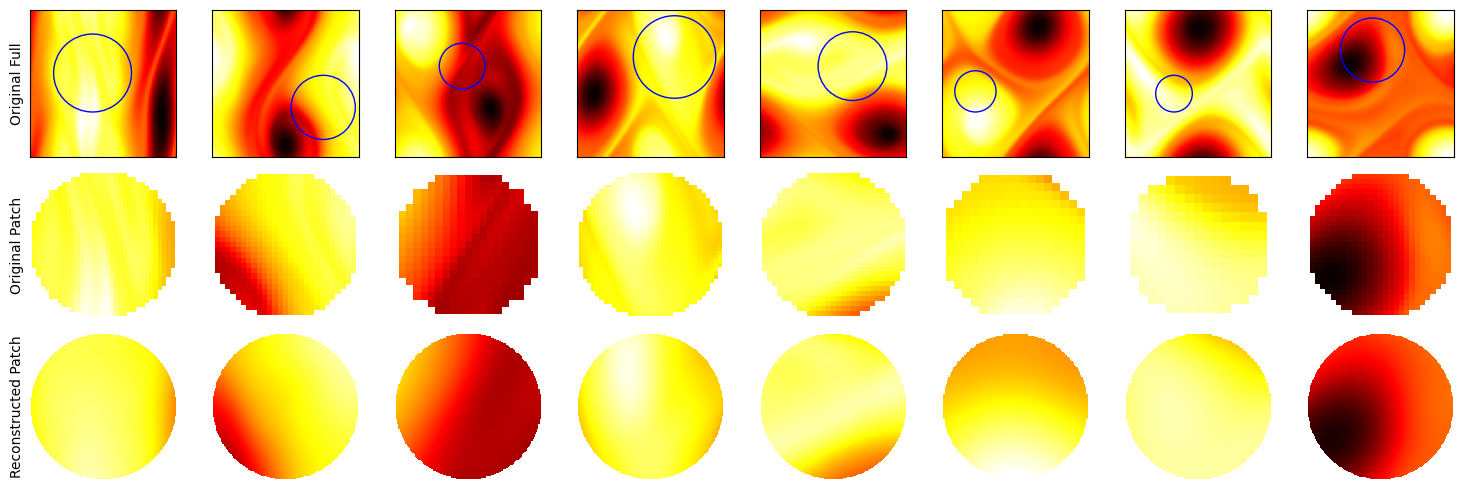

In [4]:
plt.rcParams["figure.figsize"] = (15, 5)

N_NEW = 400
N_UPSAMPLES = 8
SAVE_DIR = None
# SAVE_DIR = '../../figures/sparse_training/patch_superresolution'
# os.makedirs(SAVE_DIR, exist_ok=True)

u, x, _, _ = next(iter(test_dataloader_full))

for idx in range(N_UPSAMPLES):
    x_base = x[idx]
    u_base = u[idx]
    n_base = int(x_base.shape[0] ** 0.5)

    radius = np.random.uniform(0.1, 0.3)
    center_x = np.random.uniform(radius, 1 - radius)
    center_y = np.random.uniform(radius, 1 - radius)
    mask = get_mask_circle(n_base, radius, center_x, center_y)
    patch_shape = Circle(
        (int(center_x * n_base), int(center_y * n_base)),
        int(radius * n_base),
        linewidth=1,
        edgecolor="blue",
        facecolor="none",
    )

    vmin = u_base.min()
    vmax = u_base.max()

    mask_query = get_mask_circle(N_NEW, radius, center_x, center_y)
    x_query_square = get_raw_x(N_NEW, N_NEW)[None, ...]
    x_query = x_query_square[:, mask_query]

    z = autoencoder.encode(state, u_base[None, ...], x_base[None, ...])
    u_rec = np.zeros((N_NEW**2,)).reshape(-1, 1)
    u_rec[mask_query] = autoencoder.decode(state, z, x_query)[0]

    if SAVE_DIR is None:
        plt.subplot(3, N_UPSAMPLES, idx + 1)
        if idx == 0:
            plt.ylabel("Original Full")
    plt.imshow(u_base.reshape(n_base, n_base), cmap="hot", vmin=vmin, vmax=vmax)
    plt.gca()
    plt.gca().add_patch(patch_shape)
    plt.yticks([])
    plt.xticks([])
    if SAVE_DIR is not None:
        plt.savefig(f"{SAVE_DIR}/original_full_{n_base ** 2}_{idx}.pdf")
        plt.close()

    if SAVE_DIR is None:
        plt.subplot(3, N_UPSAMPLES, idx + 1 + N_UPSAMPLES)
        if idx == 0:
            plt.ylabel("Original Patch")
    plot_circle_patch(
        u_base, mask, n_base, radius, center_x, center_y, vmin=vmin, vmax=vmax
    )
    plt.yticks([])
    plt.xticks([])
    for spine in plt.gca().spines.values():
        spine.set_visible(False)
    if SAVE_DIR is not None:
        plt.savefig(f"{SAVE_DIR}/original_patch_{mask.sum()}_{idx}.pdf")
        plt.close()

    if SAVE_DIR is None:
        plt.subplot(3, N_UPSAMPLES, idx + 1 + 2 * N_UPSAMPLES)
        if idx == 0:
            plt.ylabel("Reconstructed Patch")
    mask_new = get_mask_circle(N_NEW, radius, center_x, center_y)
    plot_circle_patch(
        u_rec, mask_new, N_NEW, radius, center_x, center_y, vmin=vmin, vmax=vmax
    )
    for spine in plt.gca().spines.values():
        spine.set_visible(False)
    plt.yticks([])
    plt.xticks([])
    if SAVE_DIR is not None:
        plt.colorbar()
        plt.savefig(f"{SAVE_DIR}/reconstructed_patch_{mask_query.sum()}_{idx}.pdf")
        plt.close()

plt.tight_layout()
plt.show()